In [2]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from ggplot import *
import time

In [3]:
data_path = '../../data'
loans_full = pd.read_csv(data_path+"/loans_full.zip", index_col=0)
loans_details = pd.read_csv(data_path+"/loans_details.zip", index_col=0)
additional_columns =  loans_full.columns.difference(loans_details.columns).tolist() + ['id']
df = loans_details.merge(loans_full[['id', 'borrower_count']], left_on='id', right_on='id')

/Users/j/virtualenvs/delta/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (21,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/j/virtualenvs/delta/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (8,9,10,29,42,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df['expired'] = df['status']=='expired'
df = df[df['status']!='fundraising']

In [5]:
loans_full['status'].value_counts()

funded         122273
expired          4683
fundraising       944
Name: status, dtype: int64

In [6]:
df['male'] = df['borrowers'].apply(lambda x: x.split("gender': '")[1][0]=='M')
df['num_borrowers'] = df['borrowers'].apply(lambda x: len([y for y in x if y=='}']))
# convert strs to datetimes
for col in df.columns:
    if "_date" in col:
        df[col] = pd.to_datetime(df[col])
        col_root = col.split('_date')[0]
        df[col_root+"_year"] = df[col].apply(lambda x: x.year)
        df[col_root+"_month"] = df[col].apply(lambda x: x.month)
        df[col_root+"_unix"] = df[col].apply(lambda x: time.mktime(x.timetuple()) if not pd.isnull(x) else 0)
        

In [7]:
df['lat'] = df['location.geo.pairs'].apply(lambda x: x.split()[0])
df['long'] = df['location.geo.pairs'].apply(lambda x: x.split()[1])

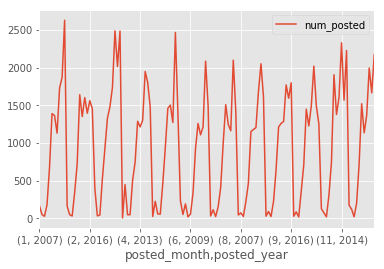

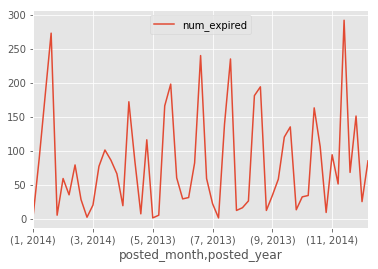

In [13]:
num_posted = pd.DataFrame(df.groupby(['posted_month', 'posted_year']).count()['activity'])
num_posted.columns = ['num_posted']
num_expired = pd.DataFrame(df[df['status']=='expired'].groupby(['posted_month', 'posted_year']).count()['activity'])
num_expired.columns = ['num_expired']
df = df.merge(num_posted, left_on=['posted_month', 'posted_year'], right_index=True)
df = df.merge(num_expired, left_on=['posted_month', 'posted_year'], right_index=True)
num_posted.plot()
num_expired.plot()

In [11]:
X = df[['expired','num_posted','lat','long','posted_unix','num_borrowers','male', 'activity', 'location.town', 'partner_id', "sector", "tags", "loan_amount"]]
rf_X = X.copy()
rf_X = rf_X.dropna()
y = rf_X['expired']
rf_X = rf_X.drop("expired", axis=1)
rf_X.columns

for col in X.columns[1:]:
    if col not in ['male','num_posted', 'num_borrowers', 'funded_unix','lat','long', 'lender_count']:
        if col=='tags':
            col_vals = ["#Woman Owned Biz", "#Parent", "user_favorite", "#Repeat Borrower", "volunteer_pick", "#Vegan", "volunteer_like","#Animals", "#Eco-friendly", "#Technology"]
        else:
            col_vals = X[col].value_counts().index[:10]
            
        for col_val in col_vals:
            if col_val not in rf_X.columns:
                rf_X[col+"_"+str(col_val)] = X[col]==col_val
            else:
                print(col, col_val)
        rf_X = rf_X.drop(col, axis=1)
    else:
        pass
    
rf = RandomForestClassifier(n_estimators=100, oob_score=True)
rf.fit(rf_X,y)
rf.oob_score_

0.95286078400920859

In [12]:
# Print Feature importances.
# Results show that time trends are the most important, followed by amount funded. Very Strange that month makes the list
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, rf_X.columns[indices[f]], importances[indices[f]]))


Feature ranking:
1. feature num_posted (0.494754)
2. feature male (0.059409)
3. feature num_borrowers (0.051151)
4. feature lat (0.042497)
5. feature long (0.042190)
6. feature loan_amount_500 (0.022026)
7. feature loan_amount_600 (0.017894)
8. feature loan_amount_300 (0.017783)
9. feature loan_amount_200 (0.016439)
10. feature partner_id_386.0 (0.014816)
11. feature loan_amount_250 (0.014020)
12. feature partner_id_138.0 (0.012419)
13. feature sector_Retail (0.010175)


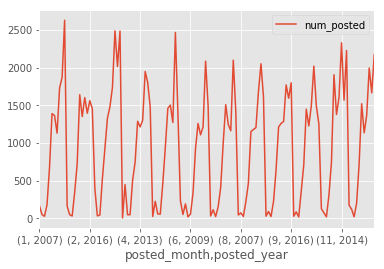

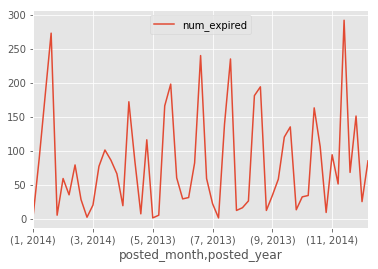

In [1]:
# Print Feature importances.
# Results show that time trends are the most important, followed by amount funded. Very Strange that month makes the list
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, rf_X.columns[indices[f]], importances[indices[f]]))


NameError: name 'rf' is not defined